In [18]:
# === importing dependencies ===#
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import ast
import yaml

import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetRegressor
import pickle
from pickle import dump, load
import joblib

import torch

from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as R2
from scipy import stats

#For reproducibility of the results, the following seeds should be selected 
from numpy.random import seed
randSeed = np.random.randint(1000)

root_dir = '/media/harish/SSD/DL_based_wind_profile_estimation'
sys.path.append(root_dir)
from libraries import *
from plotters import *

FIG_DIR = '/home/harish/Dropbox/Apps/Overleaf/NAWEA24/'

# === gather variables provided as input arguments ===
config_file = 'config_TL_ERA5_to_CERRA_to_obs.yaml'

# === load yaml file and extract variables ===
with open(config_file, 'r') as yaml_file:
    config = yaml.safe_load(yaml_file)
input_file = config['input_file']
input_times_freq = config['input_times_freq']
Coeff_file = config['Coeff_file']
input_variables = config['input_variables']
train_locations = config['train_locations']
train_dates_range = config['train_dates_range']
test_dates_range = config['test_dates_range']
test_locations = config['test_locations']
nEns = config['nEns']
tabnet_param_file = config['tabnet_param_file']
target_variables = config['target_variables']
experiment = config['experiment']
run = 0

In [19]:
coeff = xr.open_dataset(Coeff_file)
ERA5 = xr.open_dataset(input_file)
CERRA = xr.open_dataset(f'{root_dir}/data/CERRA.nc')

In [20]:
df_Obs = pd.read_csv(f'{root_dir}/data/Heligoland_wind.csv',index_col=0,parse_dates=True)
# Resampling the data to hourly frequency, by averaging the values
df_Obs = df_Obs.resample('H').mean() # this is not supposed to be, but the chebyshev coefficients are estimated using this sampling

In [21]:
obs_levels = np.array([40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 450, 500])
CERRA_levels = np.array([10., 15., 30., 50., 75., 100., 150., 200., 250., 300., 400., 500.])
ERA5_levels = [10, 100]
def profle_plotter(fig,gs,k,X,Y_CERRA,Y_obs=None,Obs=None,date=None,title=None,xlabel=None,ylabel=None,text_loc=None,xlim=None):
    axs = fig.add_subplot(gs)
    
    # plot ERA5 10m and 100m wind speeds
    ERA5_ws = X[0,0:2]
    axs.plot(ERA5_ws, ERA5_levels, 'dg', markerfacecolor='g', label='ERA5')

    # Calculate cerra profile
    M_CERRA = WindProfile(Z, Y_CERRA[0,:])
    axs.plot(M_CERRA, Z, '--r', linewidth=2, markerfacecolor='r', label='CERRA')

    # calculate the observed profile
    M_obs = WindProfile(Z, Y_obs[0,:])
    axs.plot(M_obs, Z, '-k', linewidth=2, markerfacecolor='r', label='Obs')

    # Here the trained model directories provided
    models = ['ERA5_to_CERRA/17Y','ERA5_to_obs','TL_ERA5_to_CERRA_to_obs/17Y']
    model_labels = [r'TabNet$_{CERRA}$',r'TabNet$_{Obs}$',r'TabNet$_{CERRA+Obs}$']
    line_styles = [':', '--', '-']
    line_colors = ['c', 'm', 'b']

    errRMSE = []
    for i, experiment in enumerate(models):
        # Initialize arrays to store ensemble predictions
        ensemble_predictions = np.zeros((10, len(Z)))

        for j, Ens in enumerate(np.arange(10)):
            OUTPUT_DIR = f'{root_dir}/WES/trained_models/{experiment}/run_{run}/Ens_{Ens}'

            # Load normalizer
            min_max_scaler = joblib.load(f'{OUTPUT_DIR}/min_max_scaler.joblib')

            # Load model
            fSTR = f'TabNet_HOLDOUT_Ens_{str(Ens)}.pkl'
            with open(f'{OUTPUT_DIR}/{fSTR}', "rb") as f:
                tabReg = pickle.load(f)
                Y_pred = min_max_scaler.inverse_transform(tabReg.predict(X))
            Mp = WindProfile(Z, Y_pred[0, :])
            # Store ensemble predictions
            ensemble_predictions[j, :] = Mp

        # Calculate percentiles
        median_profile = np.median(ensemble_predictions, axis=0)
        # Plot median
        axs.plot(median_profile, Z, linestyle=line_styles[i],color=line_colors[i], linewidth=2, label=model_labels[i])
        #p25_profile = np.percentile(ensemble_predictions, 25, axis=0)
        #p75_profile = np.percentile(ensemble_predictions, 75, axis=0)
        # Plot shaded regions
        #axs.fill_betweenx(Z, p25_profile, p75_profile, color='gray', alpha=0.5, label='Ensemble (p25-p75)')

        # Calculate RMSE
        errRMSE.append(np.sqrt(mse(M_obs, median_profile)))
    errRMSE.append(np.sqrt(mse(M_obs, M_CERRA)))
    
    if text_loc:
        axs.text(text_loc[0], text_loc[1], f'{model_labels[0]}: {errRMSE[0]:0.2f} m/s\n {model_labels[1]}: {errRMSE[1]:0.2f} m/s'
                 f'\n {model_labels[2]}:{errRMSE[2]:0.2f} m/s\n CERRA: {errRMSE[3]:0.2f} m/s',
                      transform=axs.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),fontsize=12)

    axs.set_xlim(xlim)
    axs.set_ylim([0, 800])

    if title is not None:
        axs.set_title(title, fontsize=14)

    if xlabel is not None:
        axs.set_xlabel(xlabel, fontsize=14)
    if not xlabel:
        axs.xaxis.set_ticks([])
    
    if ylabel is not None:
        axs.set_ylabel(ylabel, fontsize=14)
    if not ylabel:
        axs.yaxis.set_ticks([])
    
    # set fontsize for ticks
    axs.tick_params(axis='both', which='major', labelsize=14)
    
    return axs

In [29]:
# profle: best fit date, worst fit date
profile_dates = {'High shear': ['2018-04-05T13:00:00','2018-04-05T13:00:00'],
                'Low shear/well mixed':['2018-02-21T17:00:00','2018-02-22T17:00:00'],
                'LLJ': ['2018-04-10T07:00:00','2018-04-09T07:00:00'],
                'Logerthmic': ['2018-02-01T17:00:00','2018-02-01T21:00:00'],
                }
text_locs = [[0.05, 0.95],[0.05, 0.95],[0.05, 0.95],[0.05, 0.95],[0.05, 0.95],[0.6, 0.95]]

0 High shear 2018-04-05T13:00:00
0 Low shear/well mixed 2018-02-21T17:00:00
0 LLJ 2018-04-10T07:00:00
0 Logerthmic 2018-02-01T17:00:00


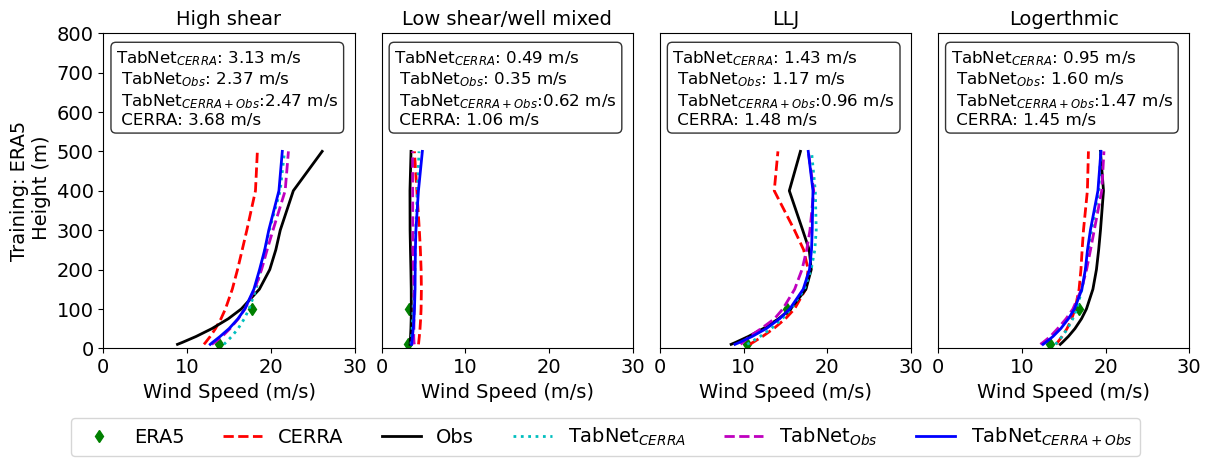

In [31]:
# best profiles
fig = plt.figure(figsize=(12, 4), constrained_layout=True)
gs = fig.add_gridspec(1,4)
xlim = [[0, 30],[0,30],[0,30],[0,30]]
i = 0
for k,profile in enumerate(profile_dates):
    print(i,profile, profile_dates[profile][0])

    X_test,Y_obs = data_processing_Heligoland(input_file,Coeff_file,input_times_freq,input_variables,target_variables,
                                    [profile_dates[profile][0],profile_dates[profile][0]],test_locations)
    X_test,Y_CERRA = data_processing(input_file,f'{root_dir}/data/Chebyshev_Coefficnents.nc',input_times_freq,input_variables,target_variables,
                                        [profile_dates[profile][0],profile_dates[profile][0]],test_locations)

    title = profile #if i == 0 else None
    xlabel = f'Wind Speed (m/s)' #if i == 4 else None
    ylabel = f'Training: ERA5\n Height (m)' if k == 0 else None
    axs = profle_plotter(fig,gs[i,k],k,X_test,Y_CERRA,Y_obs,title=title,xlabel=xlabel,ylabel=ylabel,text_loc=text_locs[k],xlim=xlim[k])

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=14)

plt.savefig(f'{FIG_DIR}/best_profiles.pdf',dpi=300,bbox_inches='tight')

0 High shear 2018-04-05T13:00:00
0 Low shear/well mixed 2018-02-22T17:00:00
0 LLJ 2018-04-09T07:00:00
0 Logerthmic 2018-02-01T21:00:00


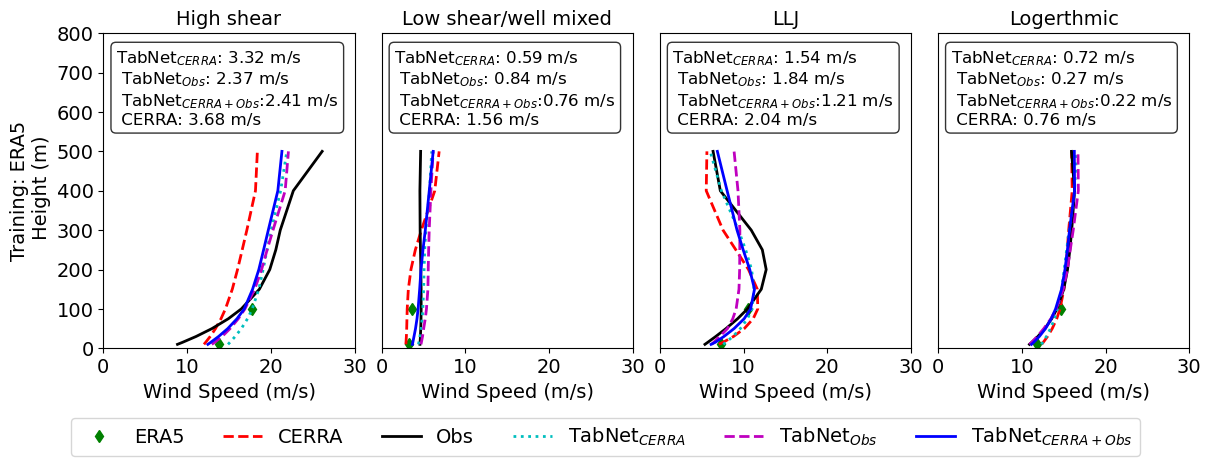

In [24]:
# best profiles
fig = plt.figure(figsize=(12, 4), constrained_layout=True)
gs = fig.add_gridspec(1,4)
i = 0
for k,profile in enumerate(profile_dates):
    print(i,profile, profile_dates[profile][1])

    X_test,Y_obs = data_processing_Heligoland(input_file,Coeff_file,input_times_freq,input_variables,target_variables,
                                    [profile_dates[profile][1],profile_dates[profile][1]],test_locations)
    X_test,Y_CERRA = data_processing(input_file,f'{root_dir}/data/Chebyshev_Coefficnents.nc',input_times_freq,input_variables,target_variables,
                                        [profile_dates[profile][1],profile_dates[profile][1]],test_locations)

    title = profile #if i == 0 else None
    xlabel = f'Wind Speed (m/s)' #if i == 4 else None
    ylabel = f'Training: ERA5\n Height (m)' if k == 0 else None
    axs = profle_plotter(fig,gs[i,k],k,X_test,Y_CERRA,Y_obs,title=title,xlabel=xlabel,ylabel=ylabel,text_loc=text_locs[k],xlim=xlim[k])

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.15),fontsize=14)

plt.savefig(f'{FIG_DIR}/worst_profiles.pdf',dpi=300,bbox_inches='tight')